# Problem 2 (10pts)

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

### 1. Show the result of PG

In [79]:
# condition
A = np.array ([[3, 0.5],
               [0.5, 1]])
mu = np.array ([[1],
                 [2]])

In [80]:
# variable definition
x_1 = np.arange (-1.5, 3, 0.01)
x_2 = np.arange (-1.5, 3, 0.02)
X1, X2 = np.mgrid [-1.5:3:0.01, -1.5:3:0.02]
f = np.zeros ((len (x_1), len (x_2)))
L = np.max (np.linalg.eig (2 * A)[0])   # gamma-smooth

In [81]:
def ST (mu, q):
  x_proj = np.zeros (mu.shape)
  for i in range (len (mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs (mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q
  return x_proj

In [82]:
def PG (lam):
  w = np.array ([[3],
                 [-1]])
  w_history = []
  for i in range (1000):
    w_history.append (w.T)
    grad = 2 * np.dot (A, w - mu)
    w = ST (w - 1 / L * grad, lam / L)
  
  w_history = np.vstack (w_history)
  return w_history

In [83]:
w_hat_lam = []
w_histories = []
lams = [2, 4, 6]

for lam in lams:
  w_history = PG (lam)
  w_hat = w_history [-1]
  w_hat_lam.append (w_hat)
  w_histories.append (w_history)
  print ('lam = {}: w_hat = ({}, {})'.format (lam, w_hat [0], w_hat[1]))

lam = 2: w_hat = (0.8181818181818182, 1.0909090909090904)
lam = 4: w_hat = (0.6363636363636365, 0.18181818181818155)
lam = 6: w_hat = (0.33333333333333337, 0.0)


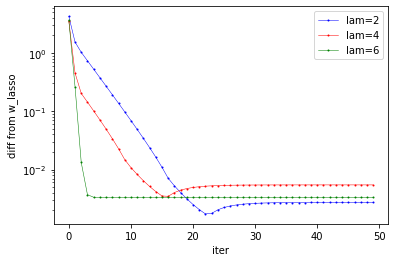

In [84]:
# diff
show_iter = 50
colors = ['bo-', 'ro-', 'go-']
w_ans_arr = [[0.82, 1.09], [0.64, 0.18], [0.33, 0]]   # from Lecutre slide

for i in range (len (lams)):
  w_history = w_histories [i]
  w_ans = w_ans_arr [i]

  plt.plot (np.abs (w_history[:show_iter, 0] - w_ans[0]) + np.abs (w_history[:show_iter, 1] - w_ans[1]), colors [i], linewidth=0.5, markersize=1, label="lam={}".format (lams [i]))
  plt.legend ()
  plt.yscale ('log')
  plt.xlabel ('iter')
  plt.ylabel ('diff from w_lasso')

lambda = 2


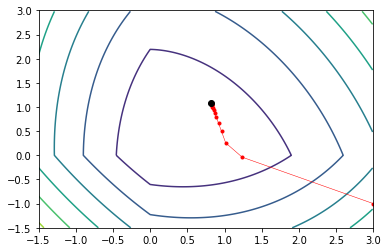

lambda = 4


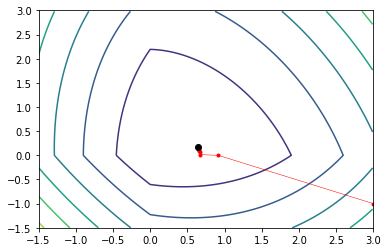

lambda = 6


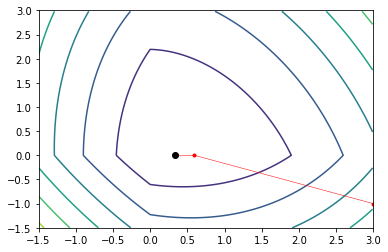

In [85]:
# trajectories

for i in range (len (x_1)):
  for j in range (len (x_2)):
    inr = np.vstack ([x_1 [i], x_2[j]])
    f [i, j] = np.dot (np.dot ((inr - mu).T, A), inr - mu) + lam * (np.abs (x_1[i]) + np.abs (x_2[j]))

for i in range (len (lams)):
  print ("lambda = {}".format (lams [i]))
  plt.contour (X1, X2, f)

  w_history = w_histories [i]
  w_ans = w_ans_arr [i]
  plt.plot (w_history [:,0], w_history [:,1], 'ro-', markersize=3, linewidth=0.5)
  plt.plot (w_ans [0], w_ans [1], 'ko')

  plt.xlim (-1.5, 3)
  plt.ylim (-1.5, 3)
  plt.show ()

### 2. Investigate concept of regularization path and plot regularization path of this lasso

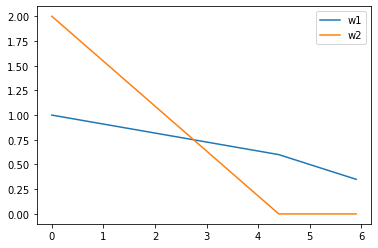

In [86]:
w_hat_lam = []
lams = np.arange (0, 6, 0.1)

for lam in lams:
  w_history = PG (lam)
  w_hat = w_history [-1]
  w_hat_lam.append (w_hat)

w1, w2 = zip (*w_hat_lam)
plt.plot (lams, w_hat_x, label='w1')
plt.plot (lams, w_hat_y, label='w2')
plt.legend ()

#### Concept of regularization path

Regularization variableであるラムダを連続的に変化させた時、現れる最適解の軌跡。

#### Disscuss the property

ラムダが小さい時、Regularization termの影響が少ないため、Loss functionを最小化するようにw1,w2が求まる。よって、ミューの値(1, 2)に近い値を取る。一方、ラムダが大きくなると、Regularization termの影響が強まり、Regularization termを最小化するようにw1,w2が求まるようになっていく。よって、ラムダが大きくなるにつれ、Regularization termを最小化する(0, 0)に近づいていく。

### 3. Investigate group lasso and implement it

In [87]:
# Dataset VI

d = 200
n = 180

groupSize = 5
attrSize = 40
g = np.arange (groupSize * attrSize).reshape (groupSize, -1)

x = np.random.randn (n, d)
noise = 0.5

# we consider feature in group 1 and group 2 is activated.
w = np.vstack ([20 * np.random.randn (80, 1),
                np.zeros ((120, 1)),
                5 * np.random.rand ()])
x_tilde = np.hstack ([x, np.ones ((n, 1))])
y = np.dot (x_tilde, w) + noise * np.random.randn (n, 1)

In [88]:
def mldivide (A, b):
  piA = np.linalg.pinv (A)
  x = np.dot (piA, b)
  return x

In [89]:
lam = 1.0
w_ridge = mldivide (np.dot (x_tilde.T, x_tilde) + lam * np.eye (d+1),
                     np.dot (x_tilde.T, y))

# cvx
west = cv.Variable ((d+1, 1))
obj_fn = \
  0.5 / n * cv.quad_form (x_tilde * west - y, np.eye (x_tilde.shape [0])) + \
  lam * (cv.norm (west[g[0]], 2.0) + \
         cv.norm (west[g[1]], 2.0) + \
         cv.norm (west[g[2]], 2.0) + \
         cv.norm (west[g[3]], 2.0) + \
         cv.norm (west[g[4]], 2.0) )
objective = cv.Minimize (obj_fn)
constraints = []

prob = cv.Problem (objective, constraints)
result = prob.solve (solver=cv.CVXOPT)

# test
x_test = np.random.randn (n, d)
x_test_tilde = np.hstack ([x_test, np.ones ((n, 1))])
y_test = np.dot (x_test_tilde, w) + noise * np.random.randn (n, 1)
y_pred = np.dot (x_test_tilde, west.value)
print (np.mean ((y_pred - y_test)**2))
# print (west.value.shape)

16.23162389513819


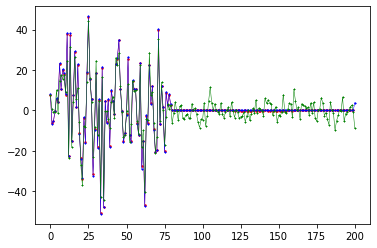

In [90]:
plt.plot (west.value[0:d], 'ro-', markersize=1.5, linewidth=0.5)
plt.plot (w, 'b*-', markersize=1.5, linewidth=0.5)
plt.plot (w_ridge, 'g-+', markersize=1.5, linewidth=0.5)

In [91]:
def group_lasso_prox (mu, q):
  x_proj = np.zeros (mu.shape)
  for i in range (len (mu)):
    if np.abs (mu[i]) > q:
      x_proj[i] = mu[i] - q * mu[i] / np.abs (mu[i])
    else:
      x_proj[i] = 0
  return x_proj

In [92]:
def PG (lam):
  w_hat = w
  L = np.max (np.linalg.eig (np.dot (x.T, x))[0])
  for i in range (1000):
    grad = 1 / n * np.dot (x_tilde.T, np.dot (x_tilde, w) - y) + 2 * lam
    w_hat = group_lasso_prox (w_hat - 1 / L * grad, lam / L)
  
  return w_hat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


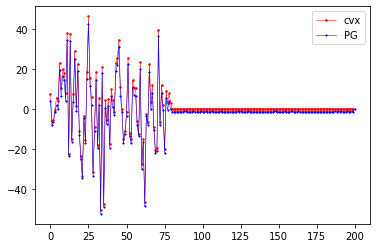

In [93]:
# proximal gradient method

w_hat = PG (1)
plt.plot (west.value[:d], 'ro-', markersize=1.5, linewidth=0.5, label='cvx')
plt.plot (w_hat, 'b*-', markersize=1.5, linewidth=0.5, label='PG')
plt.legend ()